In [1]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from obspy import read
from obspy import UTCDateTime
from torchinfo import summary
from utils import *
from autoencoder_model import *
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.covariance import EllipticEnvelope
#from pyemma import msm # not available on Kaggle Kernel
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import LabelEncoder

from sklearn.preprocessing import OneHotEncoder
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)

# Set the plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_context("talk")



# Explore an example of data

In [2]:
file_path = r"C:\Users\ahmed\OneDrive\Desktop\Cosmic Analysts\continuous_waveform\xb.elyse.00.hhv.2019.066.1.mseed"
try:
    # Attempt to read the file
    stream = read(file_path)
    print("File successfully read!")
    print(stream)
except Exception as e:
    print(f"Error reading file with ObsPy: {e}")
for tr in stream:
    print("\nTrace Statistics:")
    print(f"Network: {tr.stats.network}")
    print(f"Station: {tr.stats.station}")
    print(f"Channel: {tr.stats.channel}")
    print(f"Location: {tr.stats.location}")
    print(f"Start Time: {tr.stats.starttime}")
    print(f"End Time: {tr.stats.endtime}")
    print(f"Sampling Rate: {tr.stats.sampling_rate} Hz")
    print(f"Number of Samples: {tr.stats.npts}")
    print(f"Data Type: {tr.data.dtype}")

    # If needed, you can also access the raw data
    print(f"Data: {tr.data}")

# Print general metadata
print("\nGeneral Metadata:")
print(f"Number of Traces: {len(stream)}")

File successfully read!
4 Trace(s) in Stream:
XB.ELYSE.00.HHV | 2019-03-07T00:00:00.007000Z - 2019-03-07T01:18:45.967000Z | 100.0 Hz, 472597 samples
XB.ELYSE.00.HHV | 2019-03-07T01:18:56.970000Z - 2019-03-07T01:49:18.960000Z | 100.0 Hz, 182200 samples
XB.ELYSE.00.HHV | 2019-03-07T02:00:14.967000Z - 2019-03-07T20:02:27.957000Z | 100.0 Hz, 6493300 samples
XB.ELYSE.00.HHV | 2019-03-07T20:02:38.897000Z - 2019-03-08T00:00:00.007000Z | 100.0 Hz, 1424112 samples

Trace Statistics:
Network: XB
Station: ELYSE
Channel: HHV
Location: 00
Start Time: 2019-03-07T00:00:00.007000Z
End Time: 2019-03-07T01:18:45.967000Z
Sampling Rate: 100.0 Hz
Number of Samples: 472597
Data Type: int32
Data: [ -2493   -510  -5671 ... -17757  -3139   7437]

Trace Statistics:
Network: XB
Station: ELYSE
Channel: HHV
Location: 00
Start Time: 2019-03-07T01:18:56.970000Z
End Time: 2019-03-07T01:49:18.960000Z
Sampling Rate: 100.0 Hz
Number of Samples: 182200
Data Type: int32
Data: [ -4782  -1286  -2819 ...   8176  -6397 -13553

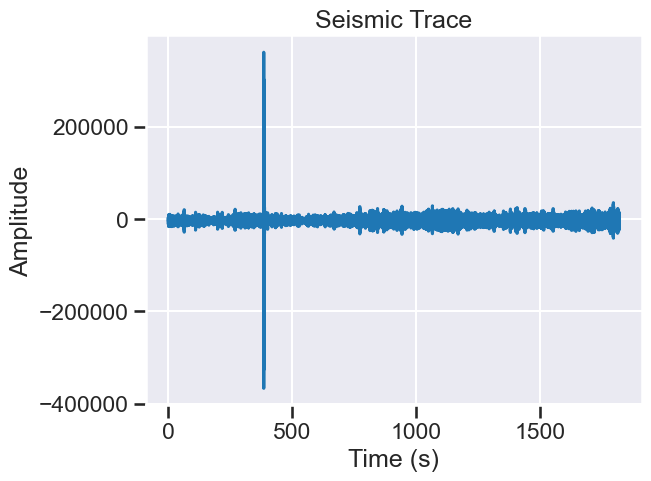

In [3]:
trace = stream[1]
plt.plot(trace.times(), trace.data)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Seismic Trace')
plt.show()

# Make DataFrame

In [4]:
# List to hold features for all files (initially empty if not starting fresh)
features_list = []
folder_path = r'C:\Users\ahmed\OneDrive\Desktop\Cosmic Analysts\continuous_waveform'
# Loop over folder and extract features
'''
for filename in os.listdir(folder_path):
    if filename.endswith(".mseed"):
        file_path = os.path.join(folder_path, filename)
        stream = read(file_path)
            
            # Extract features for each trace in the file
        for tr in stream:
            features = extract_features(tr)
            features_list.append(features)
features_df = pd.DataFrame(features_list)
'''
features_df = pd.read_csv('Mars_InSight_Lander.csv', index_col=False)

# Data Exploration

In [5]:
features_df.head()

,network,station,channel,location,start_time,end_time,sampling_rate,num_of_samples,mean,std,skewness,kurtosis,fft_mean,fft_std,energy,year,duration_seconds,start_hour,end_hour
0,XB,ELYH0,UMA,2,2018-12-02 03:01:31.107,2018-12-02 23:59:51.107,0.01,756,37859.096561,42.234511,-0.305778,-1.373608,38012.497201,1.040259e+06,1.083585e+12,2018,75500.0,3,23
1,XB,ELYH0,UMA,2,2018-12-03 00:01:30.966,2018-12-03 23:59:50.966,0.01,864,37837.818287,66.396331,-0.148999,-1.569099,38034.520633,1.111551e+06,1.236993e+12,2018,86300.0,0,23
2,XB,ELYH0,UMA,2,2018-12-04 00:01:30.817,2018-12-04 20:31:30.817,0.01,739,37839.944520,61.146386,0.127314,-1.532076,38089.402543,1.027958e+06,1.058148e+12,2018,73800.0,0,20
3,XB,ELYH0,UMA,2,2018-12-05 04:43:22.640,2018-12-05 23:58:22.640,0.01,694,37819.811239,71.187623,-0.443056,-1.388702,38174.317003,9.955907e+05,9.926582e+11,2018,69300.0,4,23
4,XB,ELYH0,UMA,2,2018-12-06 00:00:02.514,2018-12-06 21:01:42.514,0.01,758,37830.232190,62.338013,0.206913,-1.433261,38041.507763,1.040841e+06,1.084797e+12,2018,75700.0,0,21


In [6]:
features_df.drop(columns=['start_time','end_time']).nunique()

network                 1
station                 4
channel                67
location               57
sampling_rate           9
num_of_samples       3718
mean                36691
std                 36690
skewness            36936
kurtosis            36773
fft_mean            37123
fft_std             37339
energy              37276
year                    3
duration_seconds     3893
start_hour             24
end_hour               24
dtype: int64

In [7]:
# Convert obspy's UTCDateTime objects to Python datetime objects
features_df['start_time'] = features_df['start_time'].apply(lambda x: x.datetime if isinstance(x, UTCDateTime) else x)
features_df['end_time'] = features_df['end_time'].apply(lambda x: x.datetime if isinstance(x, UTCDateTime) else x)
features_df['start_time'] = pd.to_datetime(features_df['start_time'])
features_df['end_time'] = pd.to_datetime(features_df['end_time'])
features_df['year'] = features_df['start_time'].dt.year
features_df['duration_seconds'] = (features_df['end_time'] - features_df['start_time']).dt.total_seconds()
features_df['start_hour'] = features_df['start_time'].dt.hour
features_df['end_hour'] = features_df['end_time'].dt.hour

Plot features and find whether they are Gaussian or not.
Understand the reason behind some features being NaN.
Add time stamp as a feature to the CSV.

In [8]:
features_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38267 entries, 0 to 38266
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   network           38267 non-null  object        
 1   station           38267 non-null  object        
 2   channel           38267 non-null  object        
 3   location          38267 non-null  int64         
 4   start_time        38267 non-null  datetime64[ns]
 5   end_time          38267 non-null  datetime64[ns]
 6   sampling_rate     38267 non-null  float64       
 7   num_of_samples    38267 non-null  int64         
 8   mean              38267 non-null  float64       
 9   std               38267 non-null  float64       
 10  skewness          38267 non-null  float64       
 11  kurtosis          38267 non-null  float64       
 12  fft_mean          38267 non-null  float64       
 13  fft_std           38267 non-null  float64       
 14  energy            3826

In [9]:
features_df.head()

,network,station,channel,location,start_time,end_time,sampling_rate,num_of_samples,mean,std,skewness,kurtosis,fft_mean,fft_std,energy,year,duration_seconds,start_hour,end_hour
0,XB,ELYH0,UMA,2,2018-12-02 03:01:31.107,2018-12-02 23:59:51.107,0.01,756,37859.096561,42.234511,-0.305778,-1.373608,38012.497201,1.040259e+06,1.083585e+12,2018,75500.0,3,23
1,XB,ELYH0,UMA,2,2018-12-03 00:01:30.966,2018-12-03 23:59:50.966,0.01,864,37837.818287,66.396331,-0.148999,-1.569099,38034.520633,1.111551e+06,1.236993e+12,2018,86300.0,0,23
2,XB,ELYH0,UMA,2,2018-12-04 00:01:30.817,2018-12-04 20:31:30.817,0.01,739,37839.944520,61.146386,0.127314,-1.532076,38089.402543,1.027958e+06,1.058148e+12,2018,73800.0,0,20
3,XB,ELYH0,UMA,2,2018-12-05 04:43:22.640,2018-12-05 23:58:22.640,0.01,694,37819.811239,71.187623,-0.443056,-1.388702,38174.317003,9.955907e+05,9.926582e+11,2018,69300.0,4,23
4,XB,ELYH0,UMA,2,2018-12-06 00:00:02.514,2018-12-06 21:01:42.514,0.01,758,37830.232190,62.338013,0.206913,-1.433261,38041.507763,1.040841e+06,1.084797e+12,2018,75700.0,0,21


In [10]:
features_df.fillna(0,inplace=True)
features_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38267 entries, 0 to 38266
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   network           38267 non-null  object        
 1   station           38267 non-null  object        
 2   channel           38267 non-null  object        
 3   location          38267 non-null  int64         
 4   start_time        38267 non-null  datetime64[ns]
 5   end_time          38267 non-null  datetime64[ns]
 6   sampling_rate     38267 non-null  float64       
 7   num_of_samples    38267 non-null  int64         
 8   mean              38267 non-null  float64       
 9   std               38267 non-null  float64       
 10  skewness          38267 non-null  float64       
 11  kurtosis          38267 non-null  float64       
 12  fft_mean          38267 non-null  float64       
 13  fft_std           38267 non-null  float64       
 14  energy            3826

In [11]:
#features_df.to_csv('Mars_InSight_Lander.csv', index=False)

In [12]:
min_values = features_df.min()
max_values = features_df.max()
min_max_df = pd.DataFrame({'Min': min_values, 'Max': max_values})
print(min_max_df)

                                         Min                         Max
network                                   XB                          XB
station                                ELYH0                       ELYSE
channel                                  BHU                         VYO
location                                   0                          85
start_time        2018-11-30 19:05:14.982000  2020-01-27 00:00:08.064000
end_time          2018-11-30 19:05:29.982000  2020-01-28 00:00:00.074000
sampling_rate                           0.01                       100.0
num_of_samples                             1                     8640015
mean                        -33553570.307692             22035749.502591
std                                      0.0             15488074.535961
skewness                         -925.980253                   117.78986
kurtosis                                -2.0               1029789.42238
fft_mean                           10.801008       

In [13]:
'''
for col in features_df.select_dtypes(include=['float64', 'int64']).columns:
    if features_df[col].dtype=='float64':
        features_df[col] = features_df[col].astype('float32')
    elif features_df[col].dtype=='int64':
        features_df[col] = features_df[col].astype('int32')
print(features_df.info())
'''

"\nfor col in features_df.select_dtypes(include=['float64', 'int64']).columns:\n    if features_df[col].dtype=='float64':\n        features_df[col] = features_df[col].astype('float32')\n    elif features_df[col].dtype=='int64':\n        features_df[col] = features_df[col].astype('int32')\nprint(features_df.info())\n"

# Plotting various graphs based on different columns

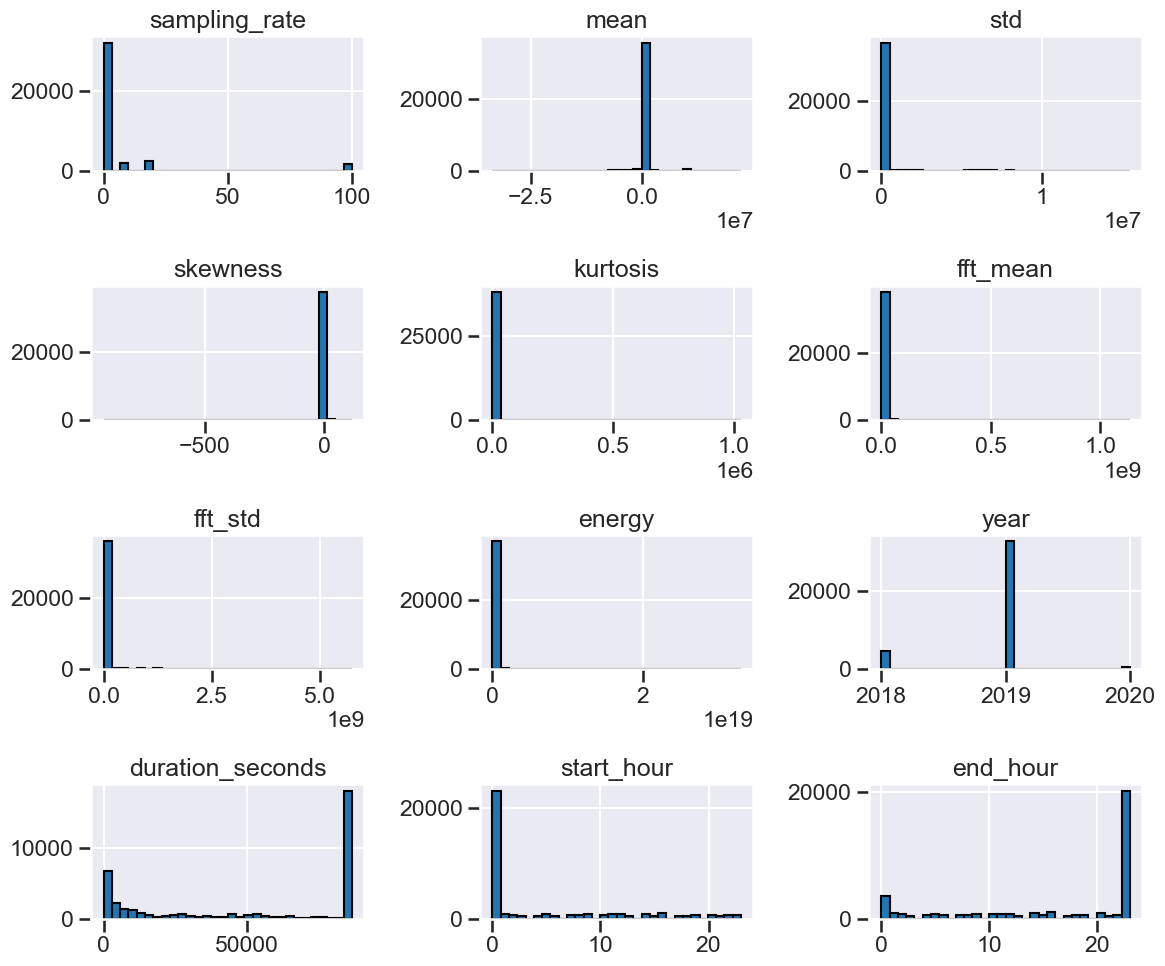

In [14]:
numerical_columns = features_df.select_dtypes(include=['float32', 'int32', 'float64', 'float32']).columns

# Plot histograms for each numerical column
features_df[numerical_columns].hist(figsize=(12, 10), bins=30, edgecolor='black')

plt.tight_layout()
plt.show()

## 1. Sampling Rate Distribution

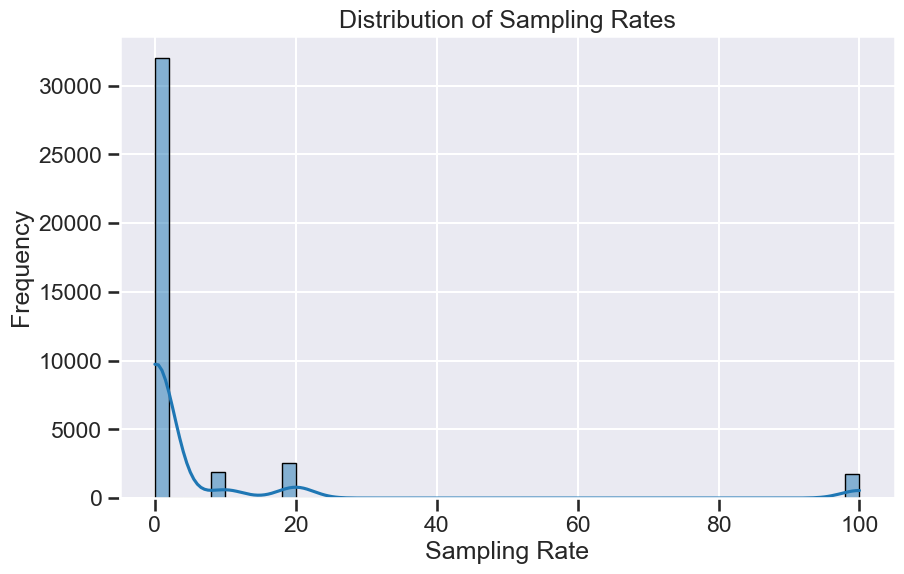

In [15]:
plt.figure(figsize=(10, 6))
sns.histplot(features_df['sampling_rate'], bins=50, kde=True)
plt.title('Distribution of Sampling Rates')
plt.xlabel('Sampling Rate')
plt.ylabel('Frequency')
plt.show()

## 2. Scatter Plot: Mean vs Standard Deviation (std)

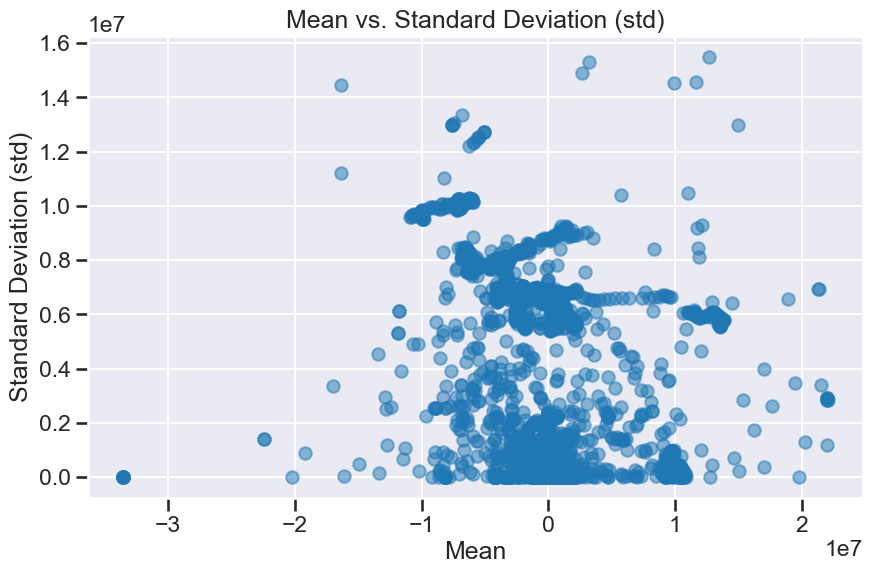

In [16]:
plt.figure(figsize=(10, 6))
plt.scatter(features_df['mean'], features_df['std'], alpha=0.5)
plt.title('Mean vs. Standard Deviation (std)')
plt.xlabel('Mean')
plt.ylabel('Standard Deviation (std)')
plt.show()

## 3. Correlation Heatmap

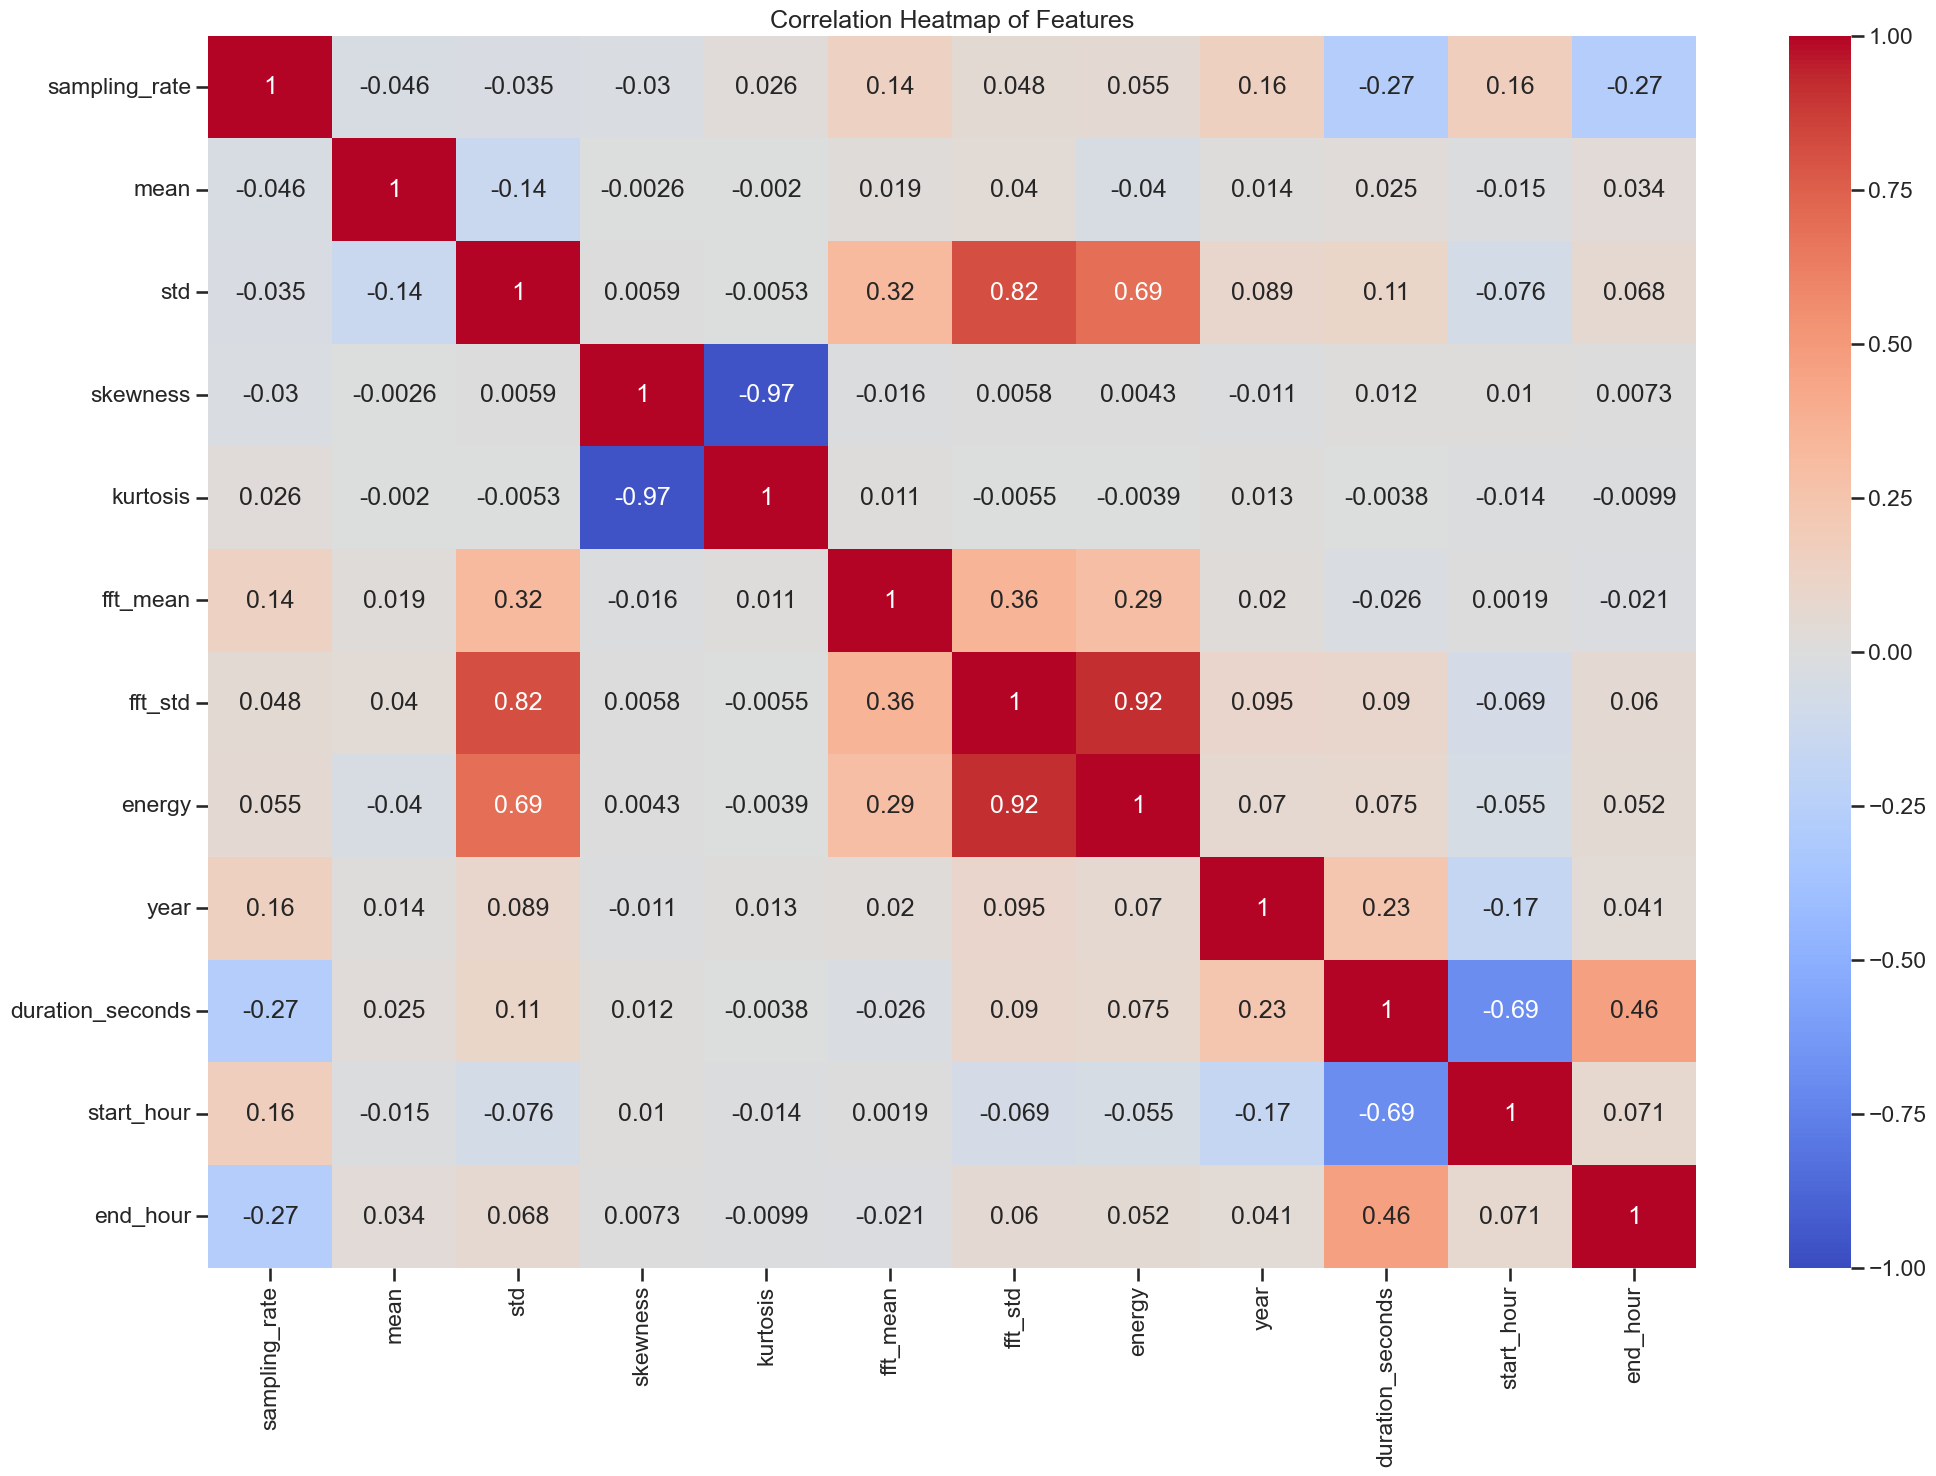

In [17]:
plt.figure(figsize=(24, 16))
corr = features_df[numerical_columns].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap of Features')
plt.show()

## 4. Boxplot of energy by Location

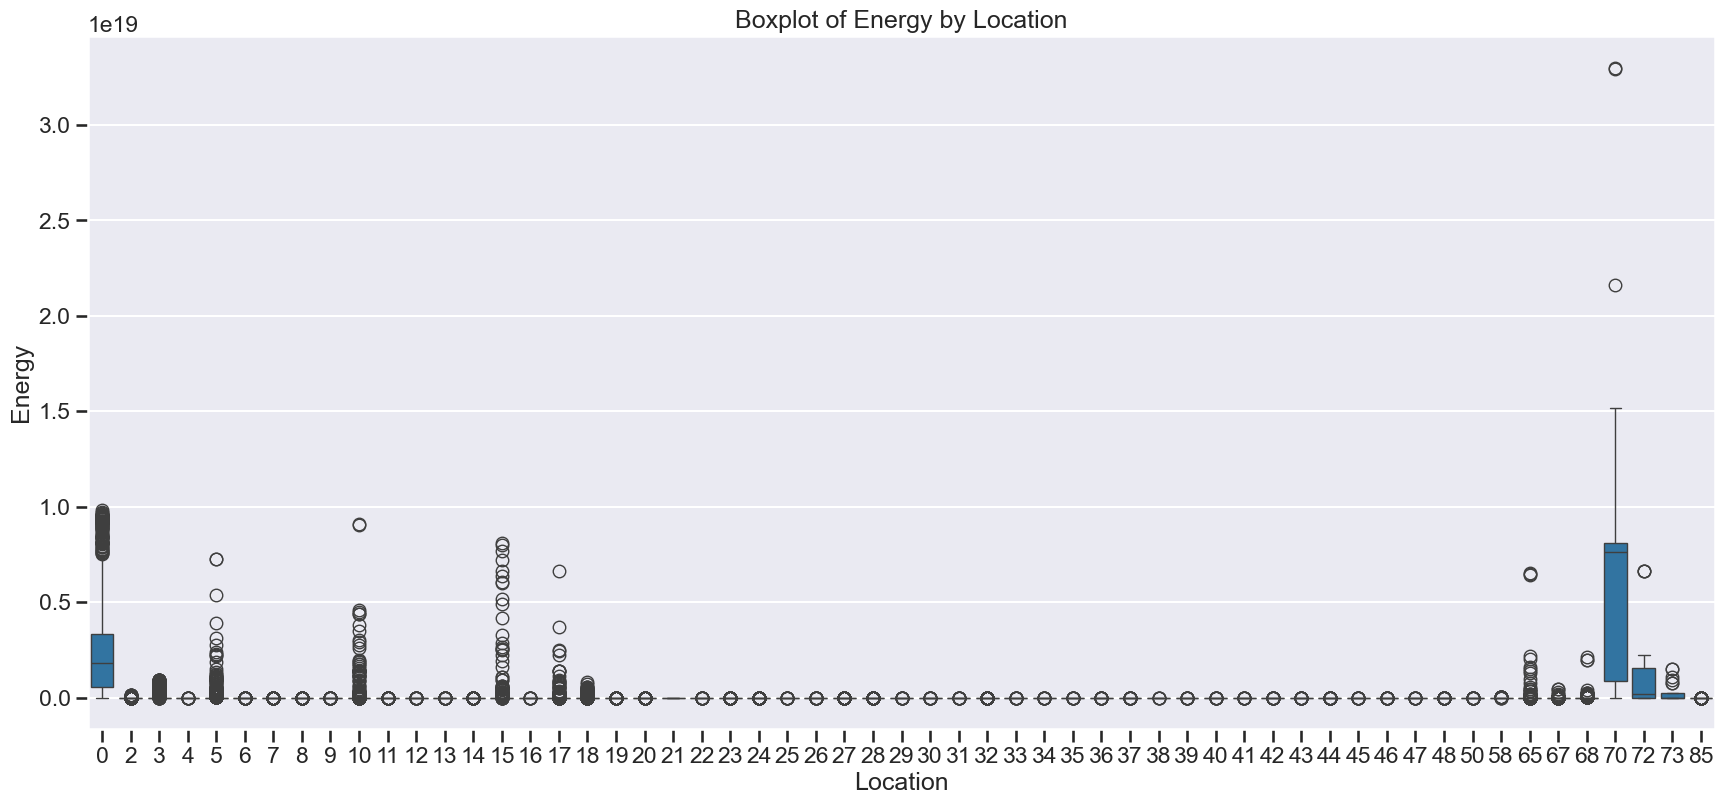

In [18]:
plt.figure(figsize=(21, 9))
sns.boxplot(x='location', y='energy', data=features_df)
plt.title('Boxplot of Energy by Location')
plt.xlabel('Location')
plt.ylabel('Energy')
plt.show()

## 5. Line Plot: Duration over time

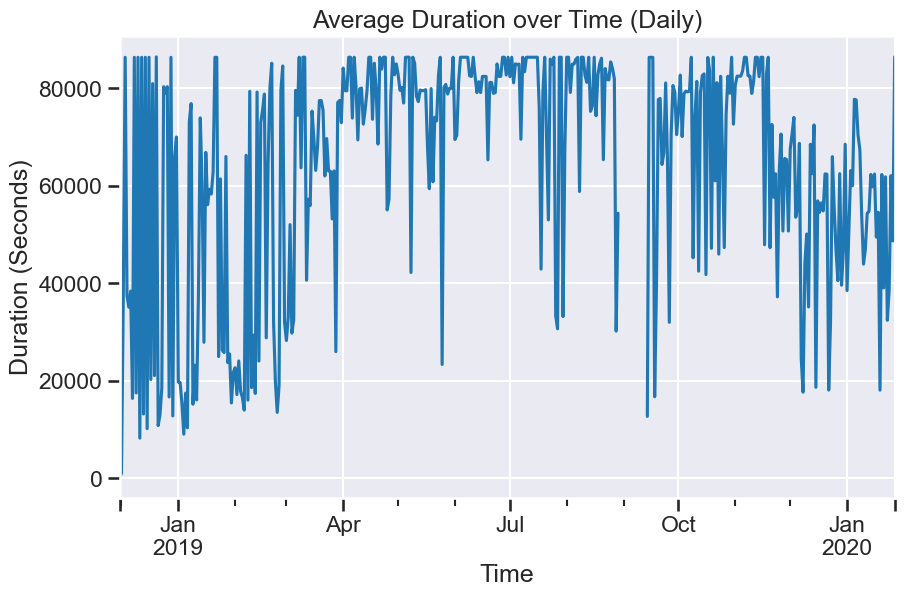

In [19]:
plt.figure(figsize=(10, 6))
features_df.set_index('start_time')['duration_seconds'].resample('D').mean().plot()
plt.title('Average Duration over Time (Daily)')
plt.ylabel('Duration (Seconds)')
plt.xlabel('Time')
plt.show()

## 6. Pairplot of Selected Features


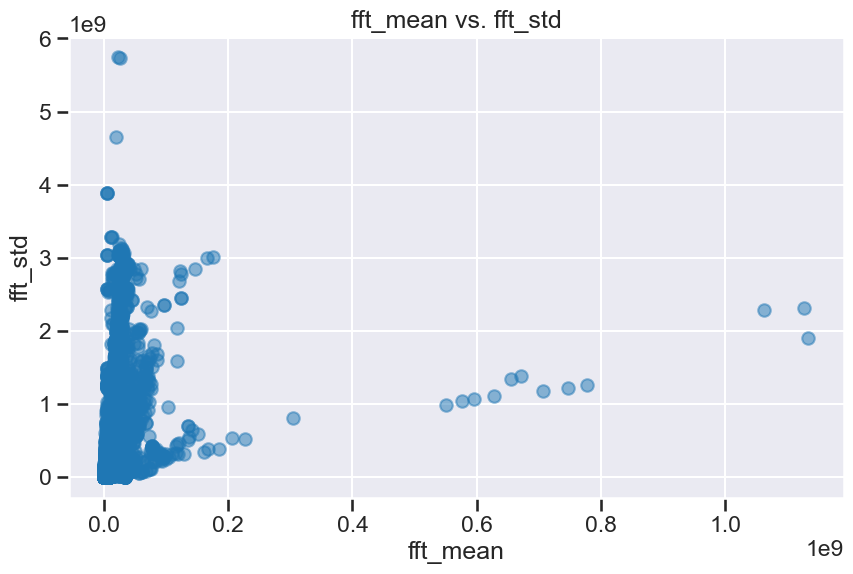

In [20]:
plt.figure(figsize=(10, 6))
plt.scatter(features_df['fft_mean'], features_df['fft_std'], alpha=0.5)
plt.title('fft_mean vs. fft_std')
plt.xlabel('fft_mean')
plt.ylabel('fft_std')
plt.show()

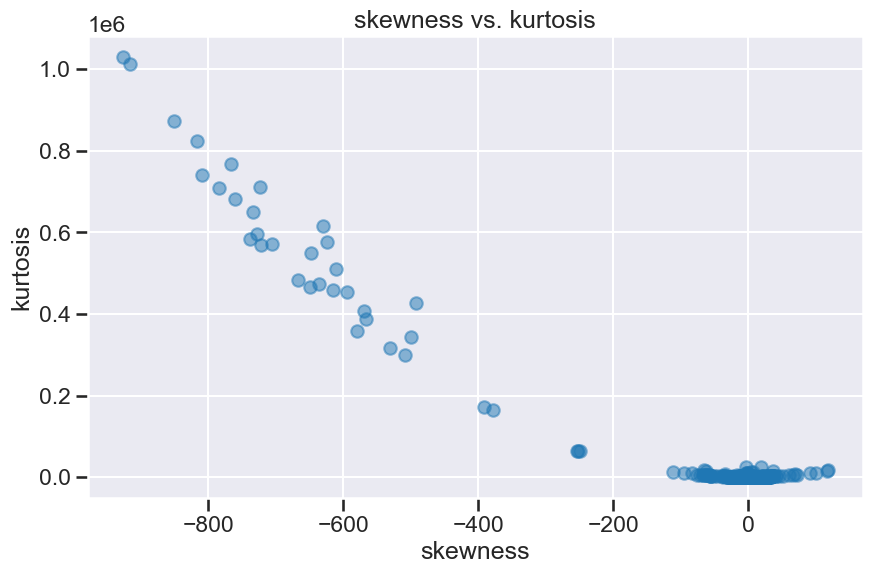

In [21]:
plt.figure(figsize=(10, 6))
plt.scatter(features_df['skewness'], features_df['kurtosis'], alpha=0.5)
plt.title('skewness vs. kurtosis')
plt.xlabel('skewness')
plt.ylabel('kurtosis')
plt.show()

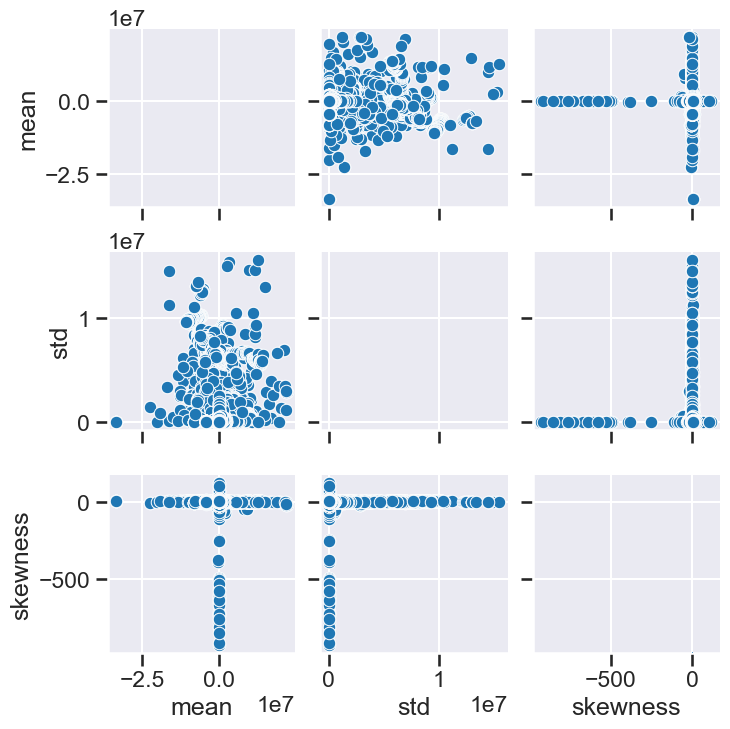

In [22]:
#'mean', 'std', 'skewness', 'kurtosis', 
sns.pairplot(features_df[['mean', 'std', 'skewness']])
plt.show()

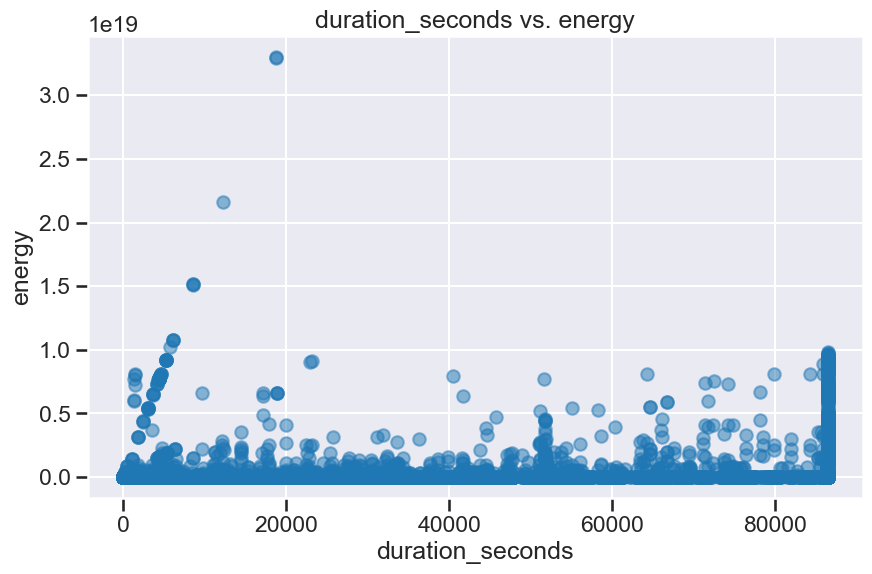

In [23]:
plt.figure(figsize=(10, 6))
plt.scatter(features_df['duration_seconds'], features_df['energy'], alpha=0.5)
plt.title('duration_seconds vs. energy')
plt.xlabel('duration_seconds')
plt.ylabel('energy')
plt.show()

## 7. Bar Plot of Start Hour Counts

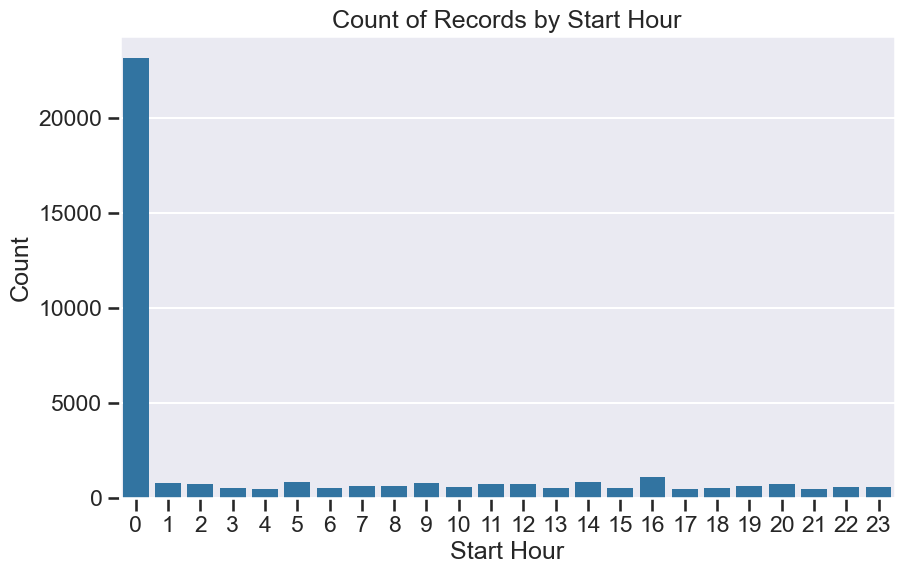

In [24]:
plt.figure(figsize=(10, 6))
sns.countplot(x='start_hour', data=features_df)
plt.title('Count of Records by Start Hour')
plt.xlabel('Start Hour')
plt.ylabel('Count')
plt.show()

## 8. Violin Plot of FFT Std by Station

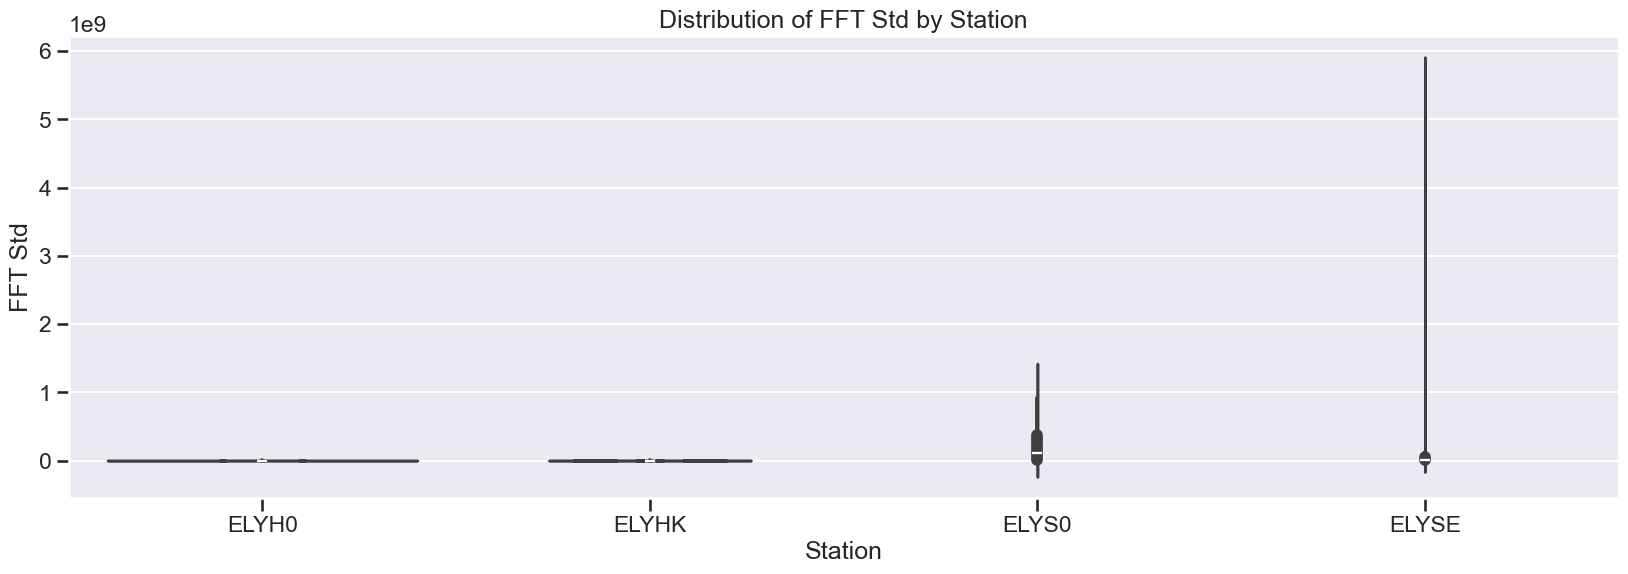

In [25]:
plt.figure(figsize=(20, 6))
sns.violinplot(x='station', y='fft_std', data=features_df)
plt.title('Distribution of FFT Std by Station')
plt.xlabel('Station')
plt.ylabel('FFT Std')
plt.show()


## 9. Histogram of Skewness and Kurtosis

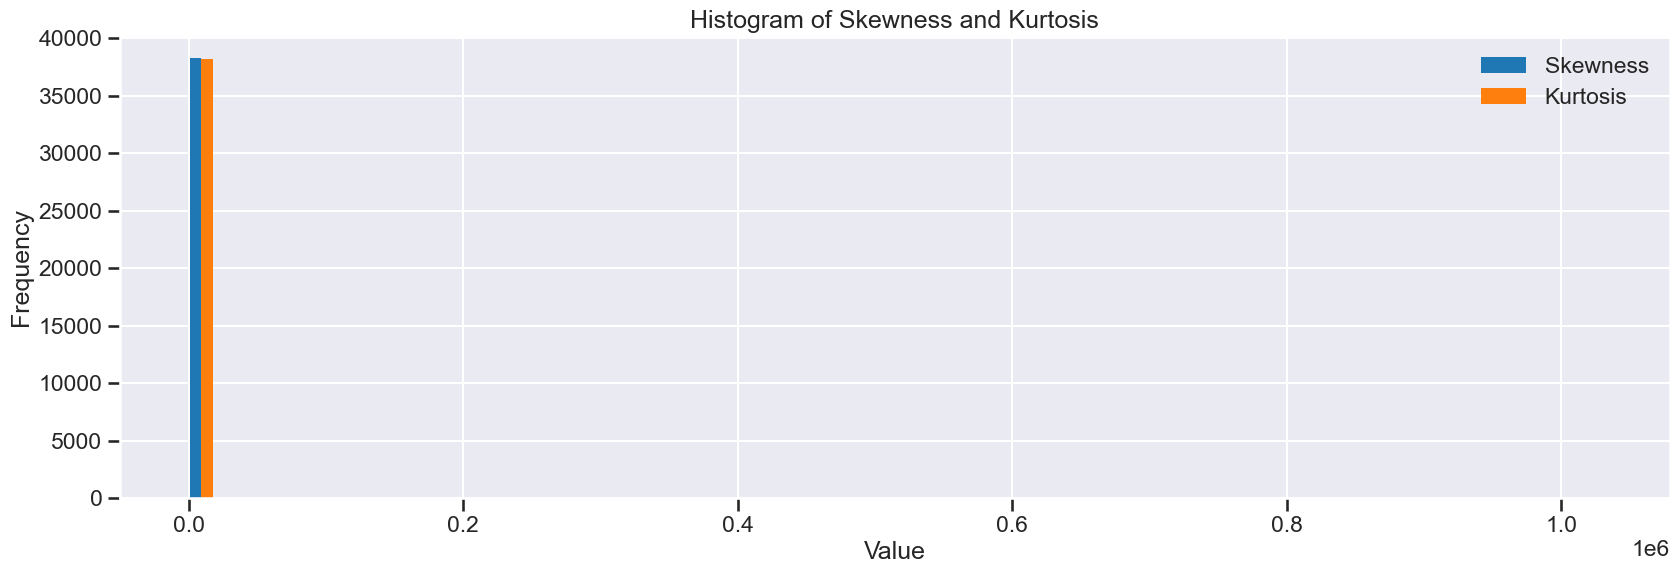

In [26]:

plt.figure(figsize=(20, 6))
plt.hist([features_df['skewness'].dropna(), features_df['kurtosis'].dropna()], bins=50, label=['Skewness', 'Kurtosis'])
plt.title('Histogram of Skewness and Kurtosis')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend()
plt.show()

## 10. Joint Plot: Energy vs Duration

In [27]:
#sns.jointplot(x='energy', y='duration_seconds', data=features_df, kind='hex', gridsize=30)
#plt.show()

# Dataset and DataLoader initialization for Autoencoder

In [28]:
'''
# Preprocessing
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features_df[numerical_columns].values)
X_train, X_temp = train_test_split(X_scaled, test_size=0.15, random_state=seed, shuffle=True)
X_test, X_val = train_test_split(X_temp, test_size=1/3, random_state=seed, shuffle=False)

# Convert the feature data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
# DataLoader for batch processing
train_dataset = TensorDataset(X_train_tensor, X_train_tensor)
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_dataset = TensorDataset(X_val_tensor, X_val_tensor)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_dataset = TensorDataset(X_test_tensor, X_test_tensor)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)
'''
cols_to_use = ['station', 'channel', 'location' , 'sampling_rate', 'num_of_samples',
                'mean', 'std', 'skewness', 'kurtosis', 'fft_mean', 'fft_std', 'energy', 'year',
                  'duration_seconds', 'start_hour', 'end_hour']
cols_to_encode = ['station', 'channel', 'location' , 'sampling_rate', 'year']
le = LabelEncoder()
for i in cols_to_encode:
    features_df[i] = le.fit_transform(features_df[i])
X_train_tensor = torch.tensor(features_df[cols_to_use].values)
train_dataset = TensorDataset(X_train_tensor, X_train_tensor)
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=False)

In [29]:
# Initialize the model
model = Autoencoder(X_train_tensor.shape[1])
print(summary(model))
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-5)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

Layer (type:depth-idx)                   Param #
Autoencoder                              --
├─Sequential: 1-1                        --
│    └─Linear: 2-1                       1,088
│    └─ReLU: 2-2                         --
│    └─Linear: 2-3                       2,080
│    └─ReLU: 2-4                         --
├─Sequential: 1-2                        --
│    └─Linear: 2-5                       2,112
│    └─ReLU: 2-6                         --
│    └─Linear: 2-7                       1,040
Total params: 6,320
Trainable params: 6,320
Non-trainable params: 0


In [30]:
train_results = train_no_val(model, train_dataloader, num_epochs=1, patience=1 ,optimizer=optimizer, scheduler=scheduler, save_dir=r"C:\Users\ahmed\OneDrive\Desktop\Cosmic Analysts\checkpoints")

Using device: cpu


  0%|          | 0/2392 [00:00<?, ?it/s]

c:\Users\ahmed\OneDrive\Desktop\Cosmic Analysts\utils.py:222: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(inputs, dtype=torch.float).to(device)
100%|██████████| 2392/2392 [00:07<00:00, 304.89it/s]

Epoch [1/1], Train Loss: inf, Anomalies: 383
No improvement in training loss for 1 consecutive epochs.
Early stopping triggered.


In [31]:
#test_results = evaluate_autoencoder(model, test_dataloader,criterion=nn.MSELoss(), device='cpu')
#test_reconstruction_errors = test_results["val_reconstruction_error"]

'\n# Plot validation reconstruction error with threshold\nplt.subplot(1, 3, 2)\nval_reconstruction_errors_flat = [item for sublist in train_results["val_reconstruction_errors"] for item in sublist]\nthreshold = np.percentile(val_reconstruction_errors_flat, 99)  \n\nplt.hist(val_reconstruction_errors_flat, bins=50, alpha=0.7, label=\'Validation Reconstruction Error\')\nplt.axvline(threshold, color=\'r\', linestyle=\'dashed\', linewidth=1, label=\'Threshold (95th Percentile)\')\nplt.xlabel(\'Reconstruction Error\')\nplt.ylabel(\'Frequency\')\nplt.title(\'Validation Error Distribution\')\nplt.legend()\n\n# Plot test reconstruction error with threshold\nplt.subplot(1, 3, 3)\nplt.hist(test_reconstruction_errors, bins=50, alpha=0.7, label=\'Test Reconstruction Error\')\nplt.axvline(threshold, color=\'r\', linestyle=\'dashed\', linewidth=1, label=\'Threshold (95th Percentile)\')\nplt.xlabel(\'Reconstruction Error\')\nplt.ylabel(\'Frequency\')\nplt.title(\'Test Error Distribution\')\nplt.legen

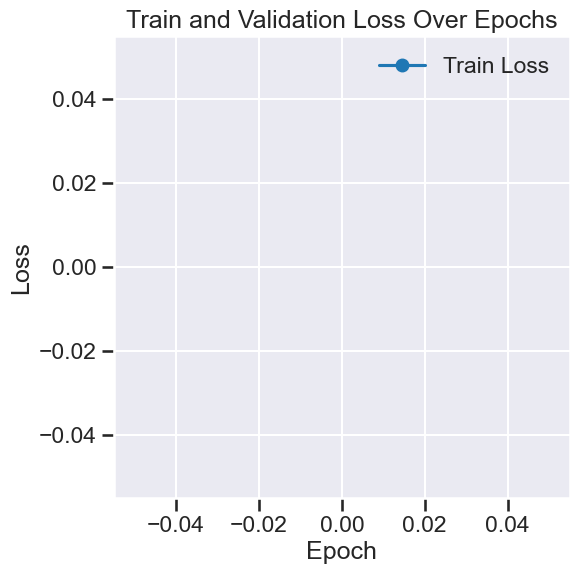

In [32]:
# Plot loss over epochs
plt.figure(figsize=(20, 6))

# Plot training and validation loss over epochs
plt.subplot(1, 3, 1)
epochs_range = range(1, len(train_results["train_loss"]) + 1)
plt.plot(epochs_range, train_results["train_loss"], label='Train Loss', marker='o')
#plt.plot(epochs_range, train_results["val_loss"], label='Validation Loss', marker='x')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Validation Loss Over Epochs')
plt.legend()
'''
# Plot validation reconstruction error with threshold
plt.subplot(1, 3, 2)
val_reconstruction_errors_flat = [item for sublist in train_results["val_reconstruction_errors"] for item in sublist]
threshold = np.percentile(val_reconstruction_errors_flat, 99)  

plt.hist(val_reconstruction_errors_flat, bins=50, alpha=0.7, label='Validation Reconstruction Error')
plt.axvline(threshold, color='r', linestyle='dashed', linewidth=1, label='Threshold (95th Percentile)')
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.title('Validation Error Distribution')
plt.legend()

# Plot test reconstruction error with threshold
plt.subplot(1, 3, 3)
plt.hist(test_reconstruction_errors, bins=50, alpha=0.7, label='Test Reconstruction Error')
plt.axvline(threshold, color='r', linestyle='dashed', linewidth=1, label='Threshold (95th Percentile)')
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.title('Test Error Distribution')
plt.legend()

# Plot validation anomalies count over epochs
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_results["val_anomalies_counts"]) + 1), train_results["val_anomalies_counts"], marker='o', color='b', label='Validation Anomalies Count')
plt.xlabel('Epoch')
plt.ylabel('Number of Anomalies')
plt.title('Validation Anomalies Count Over Epochs')
plt.legend()

plt.tight_layout()
plt.show()
'''

In [33]:
train_results["anomalies_counts"]

[383]

# Unsupervised ML

## Clustering

In [34]:
df = pd.read_csv('Mars_InSight_Lander.csv', index_col=False)
df['start_time'] = pd.to_datetime(df['start_time'])
df['end_time'] = pd.to_datetime(df['end_time'])
cols_to_use = ['station', 'channel', 'location' , 'sampling_rate', 'num_of_samples',
                'mean', 'std', 'skewness', 'kurtosis', 'fft_mean', 'fft_std', 'energy', 'year',
                  'duration_seconds', 'start_hour', 'end_hour']
cols_to_encode = ['station', 'channel', 'location' , 'sampling_rate', 'year']
le = LabelEncoder()
for i in cols_to_encode:
    df[i] = le.fit_transform(df[i])
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38267 entries, 0 to 38266
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   network           38267 non-null  object        
 1   station           38267 non-null  int32         
 2   channel           38267 non-null  int32         
 3   location          38267 non-null  int64         
 4   start_time        38267 non-null  datetime64[ns]
 5   end_time          38267 non-null  datetime64[ns]
 6   sampling_rate     38267 non-null  int64         
 7   num_of_samples    38267 non-null  int64         
 8   mean              38267 non-null  float64       
 9   std               38267 non-null  float64       
 10  skewness          38267 non-null  float64       
 11  kurtosis          38267 non-null  float64       
 12  fft_mean          38267 non-null  float64       
 13  fft_std           38267 non-null  float64       
 14  energy            3826

In [35]:
data = df[cols_to_use]
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(data)
data = pd.DataFrame(np_scaled)
# reduce to 2 importants features
pca = PCA(n_components=2)
data = pca.fit_transform(data)
# standardize these 2 new features
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(data)
data = pd.DataFrame(np_scaled)

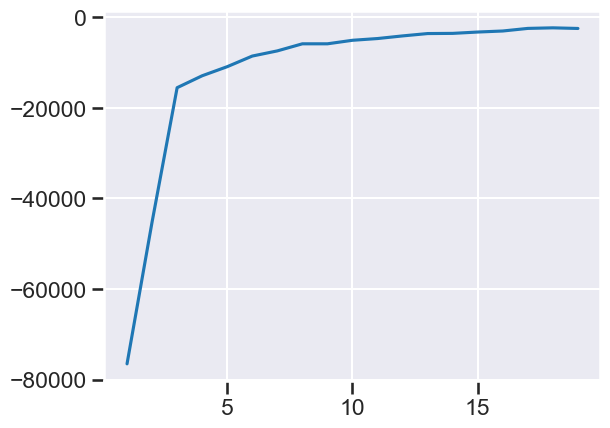

In [36]:
# calculate with different number of centroids to see the loss plot (elbow method)
n_cluster = range(1, 20)
kmeans = [KMeans(n_clusters=i).fit(data) for i in n_cluster]
scores = [kmeans[i].score(data) for i in range(len(kmeans))]
fig, ax = plt.subplots()
ax.plot(n_cluster, scores)
plt.show()

In [37]:
# I choose 10 centroids arbitrarily and add these data to the central dataframe
df['cluster'] = kmeans[5].predict(data)
df['principal_feature1'] = data[0]
df['principal_feature2'] = data[1]
df['cluster'].value_counts()

cluster
1    17102
4    10197
0     5276
3     3935
5     1036
2      721
Name: count, dtype: int64

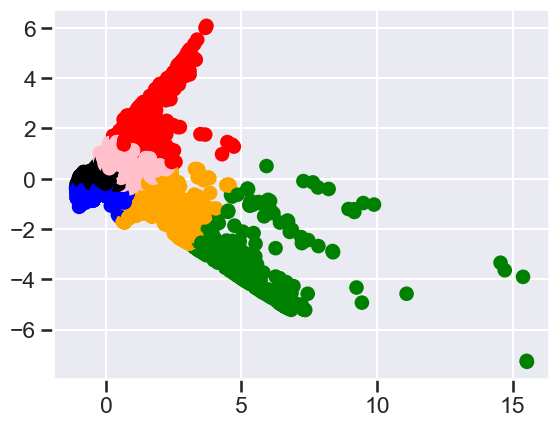

In [38]:
#plot the different clusters with the 2 main features
fig, ax = plt.subplots()
colors = {0:'red', 1:'blue', 2:'green', 3:'pink', 4:'black', 5:'orange', 6:'cyan', 7:'yellow', 8:'brown', 9:'purple', 10:'white', 11: 'grey', 12:'lightblue', 13:'lightgreen', 14: 'darkgrey'}
ax.scatter(df['principal_feature1'], df['principal_feature2'], c=df["cluster"].apply(lambda x: colors[x]))
plt.show()

In [39]:
# get the distance between each point and its nearest centroid. The biggest distances are considered as anomaly
def getDistanceByPoint(data, model):
    distance = pd.Series()
    for i in range(0,len(data)):
        Xa = np.array(data.loc[i])
        Xb = model.cluster_centers_[model.labels_[i]-1]
        distance.at[i] = np.linalg.norm(Xa - Xb)
    return distance
outliers_fraction = 0.01
distance = getDistanceByPoint(data, kmeans[14])
number_of_outliers = int(outliers_fraction*len(distance))
threshold = distance.nlargest(number_of_outliers).min()
# anomaly21 contain the anomaly result of method 2.1 Cluster (0:normal, 1:anomaly) 
df['anomaly21'] = (distance >= threshold).astype(int)
print(df['anomaly21'].value_counts())

anomaly21
0    37885
1      382
Name: count, dtype: int64


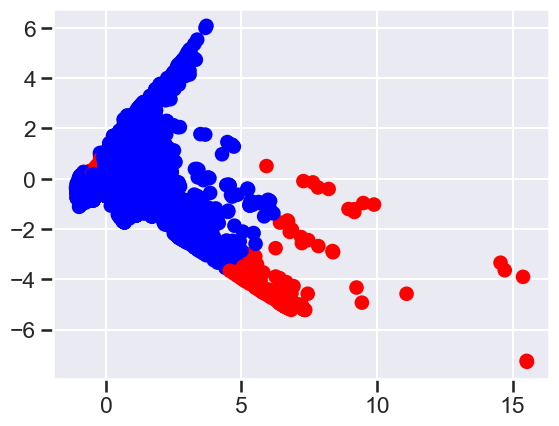

In [40]:
# visualisation of anomaly with cluster view
fig, ax = plt.subplots()
colors = {0:'blue', 1:'red'}
ax.scatter(df['principal_feature1'], df['principal_feature2'], c=df["anomaly21"].apply(lambda x: colors[x]))
plt.show()

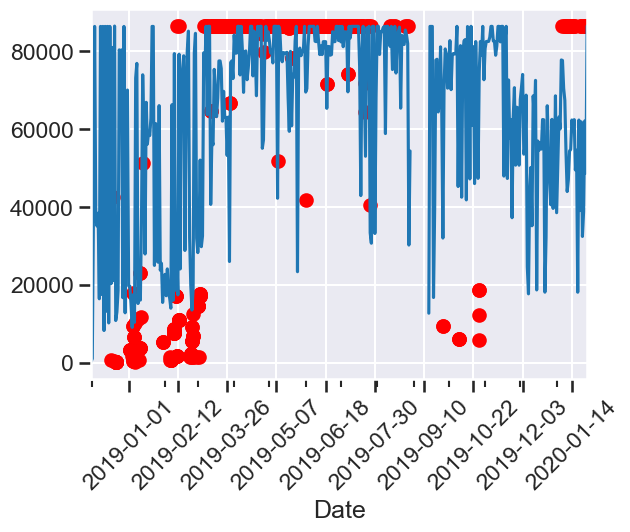

In [41]:
import matplotlib.dates as mdates
# Select anomaly data
a = df.loc[df['anomaly21'] == 1, ['start_time', 'duration_seconds']]

fig, ax = plt.subplots()

# Convert datetime64 to numerical format using mdates.date2num
a['start_time_num'] = mdates.date2num(a['start_time'])

# Resample and plot the average duration per day
df.set_index('start_time')['duration_seconds'].resample('D').mean().plot(ax=ax)

# Plot anomalies using the converted numerical dates
ax.scatter(a['start_time_num'], a['duration_seconds'], color='red')

# Simplify date formatting on x-axis
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=6))  # Show labels only for every nth day (change interval as needed)

# Rotate date labels for better visibility
plt.xticks(rotation=45)

# Add x-axis label instead of individual dates
plt.xlabel('Date')

plt.show()



## Isolation Forest

In [42]:
data = df[cols_to_use]
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(data)
data = pd.DataFrame(np_scaled)
# train isolation forest 
model =  IsolationForest(contamination = outliers_fraction)
model.fit(data)
# add the data to the main  
df['anomaly25'] = pd.Series(model.predict(data))
df['anomaly25'] = df['anomaly25'].map( {1: 0, -1: 1} )
print(df['anomaly25'].value_counts())

anomaly25
0    37884
1      383
Name: count, dtype: int64


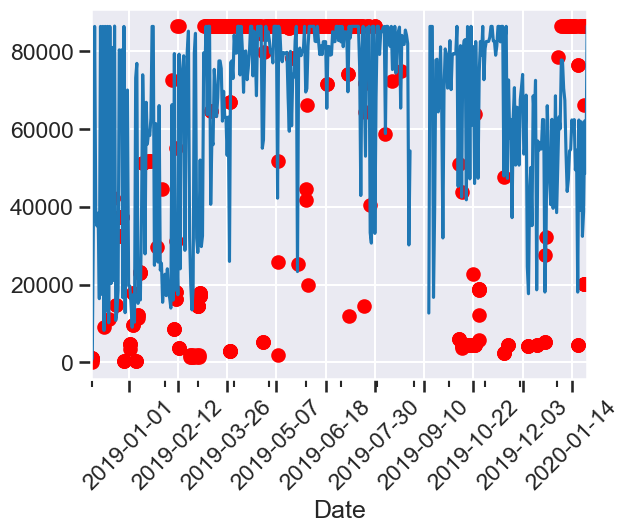

In [43]:
a = df.loc[df['anomaly25'] == 1, ['start_time', 'duration_seconds']]
# Convert datetime64 to numerical format using mdates.date2num
a['start_time_num'] = mdates.date2num(a['start_time'])

fig, ax = plt.subplots()

# Convert datetime64 to numerical format using mdates.date2num
a['start_time_num'] = mdates.date2num(a['start_time'])

# Resample and plot the average duration per day
df.set_index('start_time')['duration_seconds'].resample('D').mean().plot(ax=ax)

# Plot anomalies using the converted numerical dates
ax.scatter(a['start_time_num'], a['duration_seconds'], color='red')

# Simplify date formatting on x-axis
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=6))  # Show labels only for every nth day (change interval as needed)

# Rotate date labels for better visibility
plt.xticks(rotation=45)

# Add x-axis label instead of individual dates
plt.xlabel('Date')

plt.show()

## One Class SVM

In [44]:
data = df[cols_to_use]
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(data)
data = pd.DataFrame(np_scaled)
# train one class SVM 
model =  OneClassSVM(nu=0.95 * outliers_fraction) #nu=0.95 * outliers_fraction  + 0.05
data = pd.DataFrame(np_scaled)
model.fit(data)
# add the data to the main  
df['anomaly26'] = pd.Series(model.predict(data))
df['anomaly26'] = df['anomaly26'].map( {1: 0, -1: 1} )
print(df['anomaly26'].value_counts())

anomaly26
0    37881
1      386
Name: count, dtype: int64


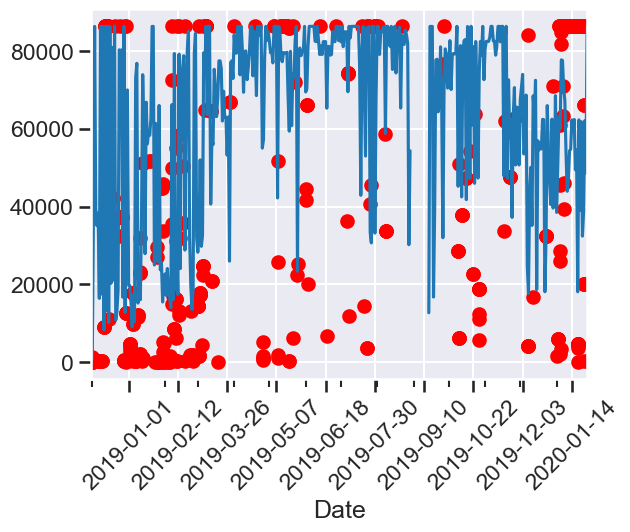

In [45]:
a = df.loc[df['anomaly26'] == 1, ['start_time', 'duration_seconds']]
# Convert datetime64 to numerical format using mdates.date2num
a['start_time_num'] = mdates.date2num(a['start_time'])

fig, ax = plt.subplots()

# Convert datetime64 to numerical format using mdates.date2num
a['start_time_num'] = mdates.date2num(a['start_time'])

# Resample and plot the average duration per day
df.set_index('start_time')['duration_seconds'].resample('D').mean().plot(ax=ax)

# Plot anomalies using the converted numerical dates
ax.scatter(a['start_time_num'], a['duration_seconds'], color='red')

# Simplify date formatting on x-axis
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=6))  # Show labels only for every nth day (change interval as needed)

# Rotate date labels for better visibility
plt.xticks(rotation=45)

# Add x-axis label instead of individual dates
plt.xlabel('Date')

plt.show()